In [1]:
import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import cv2, 
import random
import json
import csv
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
from tensorflow.keras import optimizers
from sklearn.metrics import classification_report, confusion_matrix,precision_score, recall_score,f1_score
import os
!git clone https://github.com/MarceloCMiguel/data-augmentation

Cloning into 'data-augmentation'...
remote: Enumerating objects: 3039, done.
remote: Counting objects: 100% (3039/3039), done.
remote: Compressing objects: 100% (3031/3031), done.
remote: Total 3039 (delta 8), reused 3023 (delta 4), pack-reused 0
Receiving objects: 100% (3039/3039), 67.93 MiB | 15.69 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [2]:
np.random.seed(20)


In [3]:
TRAIN_DIR = './cats_and_dogs_filtered/train/'
TEST_DIR = './cats_and_dogs_filtered/validation/'

ROWS = 150
COLS = 150
CHANNELS = 3

BATCH_SIZE=128

In [4]:
# Criando uma lista das imagens de treino totais e listas separadas para cada animal
original_train_images=[]
for i in os.listdir(TRAIN_DIR):
    #original_train_images.append(os.listdir(TRAIN_DIR+i))
    if i == 'dogs':
        train_dogs = os.listdir(TRAIN_DIR+i)
    if i == 'cats':
        train_cats = os.listdir(TRAIN_DIR+i)
    for images in os.listdir(TRAIN_DIR+i):
        original_train_images.append(f'{TRAIN_DIR}{i}/{images}')

random.shuffle(original_train_images)

#Separando a base de dados de treinamento em treinamento e validação
train_images = original_train_images[:1900]
validation_images = original_train_images[1900:]
print(len(train_images),len(validation_images))

1900 100


In [5]:
test_images=[]
for i in os.listdir(TEST_DIR):
    #print(TEST_DIR+i)
    for images in os.listdir(TEST_DIR+i):
        test_images.append(f'{TEST_DIR}{i}/{images}')

In [6]:
random.shuffle(test_images)

In [7]:
def plot_arr(arr):
    plt.figure()
    plt.imshow(image.array_to_img(arr))
    plt.show()

def plot(img):
    plt.figure()
    plt.imshow(img)
    plt.show()

In [8]:
def prep_data(images):
    count = len(images)
    X = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.float32)
    y = np.zeros((count,), dtype=np.float32)
    print("Starting")
    for i, image_file in enumerate(images):
        img = image.load_img(image_file, target_size=(ROWS, COLS))
        X[i] = image.img_to_array(img)
        if 'dog.' in image_file:
            y[i] = 1.
        i+=1
        if i == count:
            print('Processed {} of {}'.format(i, count))
        else:
            if i%1000 == 0: print('Processed {} of {}'.format(i, count))
        
    return X, y


In [9]:
X_train, y_train = prep_data(train_images)

Starting
Processed 1000 of 1900
Processed 1900 of 1900


In [10]:
X_validation, y_validation = prep_data(test_images)

Starting
Processed 1000 of 1000


In [11]:
train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    )

validation_datagen = image.ImageDataGenerator(rescale=1./255)


In [12]:
train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size=BATCH_SIZE)

validation_generator = validation_datagen.flow(
    X_validation,
    y_validation,
    batch_size=BATCH_SIZE)

In [13]:
def plot_images(datagen):
  # generate samples and plot
  for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = datagen.next()
    # convert to unsigned integers for viewing
    image_ = batch[0]
    # plot raw pixel data
    plt.imshow(image_[0])
  plt.show()


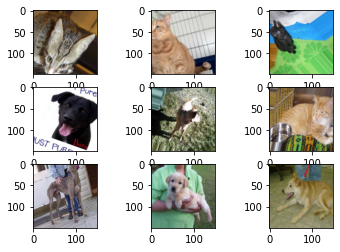

In [14]:
plot_images(train_generator)

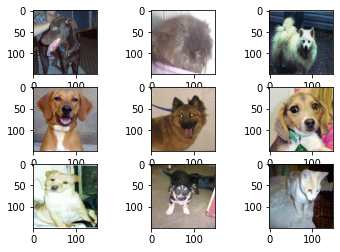

In [15]:
plot_images(validation_generator)

In [16]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(ROWS, COLS, CHANNELS)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
#     model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2)))
#     model.add(Conv2D(256, (3, 3), activation='relu'))
#     model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    # model.add(Dense(1024, activation='relu'))
    # model.add(Dense(1000, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    return model
# def create_model():
#     model = Sequential()
#     model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(ROWS, COLS, CHANNELS)))
#     model.add(MaxPooling2D(pool_size=(2,2)))

#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2)))

#     model.add(Flatten())
#     model.add(Dense(64))

#     model.add(Dense(1,activation='sigmoid'))
#     return model


In [17]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 35, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 33, 33, 128)       7

In [18]:
model.compile(loss='binary_crossentropy',
             optimizer="adam",
             metrics=['accuracy'])

In [19]:
train_steps = len(train_images)/BATCH_SIZE
#validation_steps = len(validation_images)/BATCH_SIZE
validation_steps = len(test_images)/BATCH_SIZE
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
#     steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps,
#     validation_steps=len(validation_generator),
    verbose=2)


Epoch 1/2
14/14 - 50s - loss: 0.7111 - accuracy: 0.4905 - val_loss: 0.6926 - val_accuracy: 0.5490 - 50s/epoch - 3s/step
Epoch 2/2
14/14 - 12s - loss: 0.6932 - accuracy: 0.5132 - val_loss: 0.6928 - val_accuracy: 0.5170 - 12s/epoch - 819ms/step


In [20]:
for i in history.history:
  print(i)

loss
accuracy
val_loss
val_accuracy


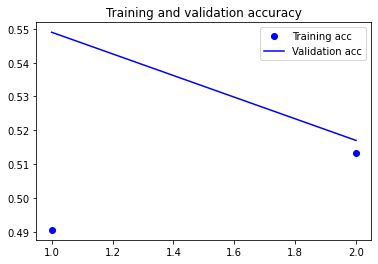

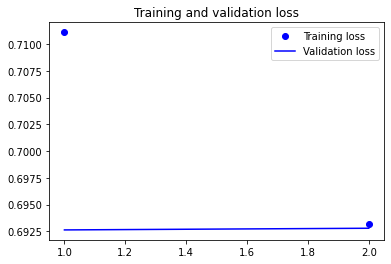

In [21]:
#acc = history.history['acc']
#val_acc = history.history['val_acc']
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [22]:
model.save('dogs-v-cat-data-augmentation-04.h5')

In [23]:
# evaluate model
_, acc = model.evaluate_generator(validation_generator, steps=validation_steps, verbose=0)
print('> %.3f' % (acc * 100.0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


> 51.700


In [24]:
X_test, y_test = prep_data(test_images)
X_test /= 255.

Starting
Processed 1000 of 1000


In [25]:
#random.shuffle(X_test)
predictions = model.predict(X_test)

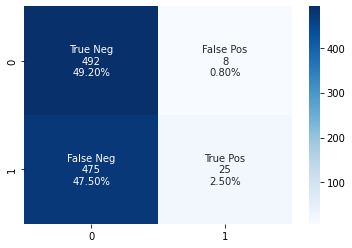

In [26]:
y_pred = (predictions > 0.5)

matrix = confusion_matrix(y_test,y_pred)

group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     matrix.flatten()/np.sum(matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix, annot=labels, fmt="", cmap='Blues')


#sns.heatmap(matrix/np.sum(matrix), annot=True,fmt='.2%', cmap='Blues')

In [27]:
precision = precision_score(y_test, y_pred, average='binary')
print('Precision: %.3f' % precision)

recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %.3f' % recall)

f1_score_ = f1_score(y_test, y_pred, average='binary')
print('F1 score_: %.3f' % f1_score_)


Precision: 0.758
Recall: 0.050
F1 score_: 0.094


I am 50.12% sure this is a Cat


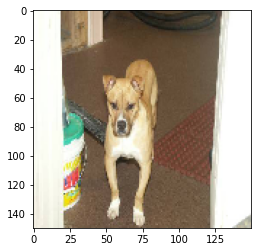

I am 50.16% sure this is a Cat


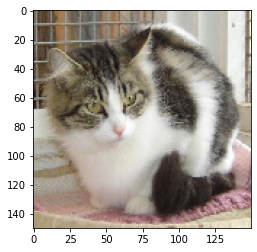

I am 50.17% sure this is a Cat


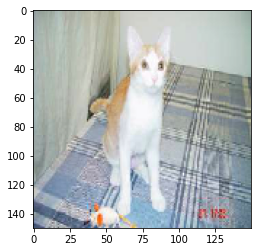

I am 50.17% sure this is a Cat


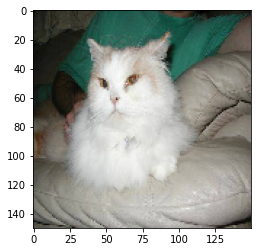

I am 50.17% sure this is a Cat


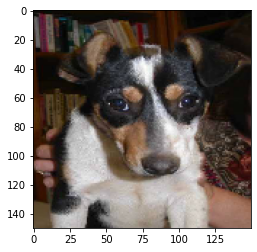

I am 50.15% sure this is a Cat


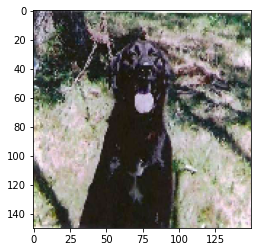

I am 50.18% sure this is a Cat


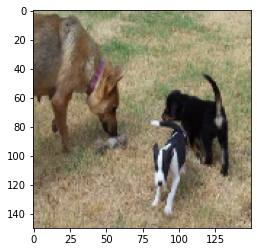

I am 50.26% sure this is a Cat


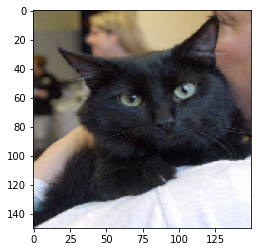

I am 50.18% sure this is a Cat


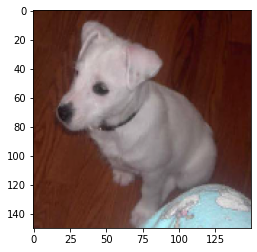

I am 50.01% sure this is a Dog


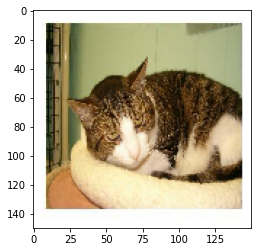

In [28]:
for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))

    plt.imshow(image.array_to_img(X_test[i]))
    plt.show()
